# PART A - TensorFlow and the Low Level API (Question1_3)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.utils import np_utils

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from google.colab import files

plt.style.use("default") # Set default layout for matplotlib's charts

print('All modules imported correctly')
print('Running TensorFlow version:', tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


All modules imported correctly
Running TensorFlow version: 2.2.0-rc2


**Helper functions for this notebook:**

In [0]:
def plot_training_data(training_container, n_epochs, save_fig=False):

  """ Visualize the training process of a Neural Network.
  Plot up to 5 different metrics.  """
  
  # Get the keys of the container (metrics to be plotted)
  metrics = list(training_container.keys())
  # Support for 5 different colors
  colors = ['dimgray', 'steelblue', 'salmon', 'darkseagreen', 'violet']
  if len(metrics) > 5:
    raise ValueError('This function can only plot up to 5 metrics.')
  
  # Plot a single linechart with all the training metrics
  plt.figure(figsize = (7,6))
  for metric in range(len(metrics)):
    plt.plot(np.arange(0, n_epochs), training_container[metrics[metric]], 
             label=metrics[metric], color=colors[metric])
    
  plt.legend()
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  
  if save_fig:
    plt.savefig('training_data_reg.png', dpi=400, bbox_inches='tight')
    files.download('training_data.png')

  plt.show()

def plot_misclassified_images(n_examples, predicted_class, predicted_probability, testX, testY, save_fig=False):

  """ Select a random number of images in the test set that were classified incorreclty 
  and plot them horizontally annotating the actual and predicted class """

  image_size = round(1.2 * n_examples)
  predicted_probability = np.amax(predicted_probability, axis=0)
  class_examples = []
  # Get the index of the images misclassified
  errors_index = np.where(predicted_class != testY)[0]
  # Random selection of images
  misclassified = np.random.choice(errors_index, size=n_examples)
  f, position = plt.subplots(1, (n_examples-1), figsize=(image_size, image_size))
  # Plot selected images
  for image in range(n_examples-1):
    figure = position[image].\
     imshow(testX[misclassified[image],:].reshape(28, 28), # 28x28 images
            interpolation='nearest', 
            cmap = 'gray')
    # Hide axes
    figure.axes.get_xaxis().set_visible(False)
    figure.axes.get_yaxis().set_visible(False)
    # Annotate images with the corresponding class labes
    position[image].\
      text(14, 33, 'Actual: {}'.format(class_mapping[testY[misclassified[image]].numpy()]), fontsize=9,
       horizontalalignment='center', verticalalignment='center')
    position[image].\
      text(14, 39, 'Pred: {}'.format(class_mapping[predicted_class[misclassified[image]].numpy()]), fontsize=9,
       horizontalalignment='center', verticalalignment='center')
    position[image].\
      text(14, 45, 'Prob: {:.2%}'.format(predicted_probability[misclassified[image]]), fontsize=8,
       horizontalalignment='center', verticalalignment='center')
      
  if save_fig:
    plt.savefig('classification_errors.png', dpi=400)
    files.download('classification_errors.png')
    
  plt.show()

def summary_report(evaluation, testY, predicted_class, save_fig=False):

  """" Print a summary report including a confusion matrix given some test data. """

  # Print data resulting from Kera's evaluate method
  print(' ')
  print('****** SUMMARY REPORT ******')
  print('---------------------------')
  print('Loss on test set: {loss}'.format(loss=round(evaluation[0], 3)))
  print('Accuracy on test set: {accuracy}'.format(accuracy=round(evaluation[1], 3)))
  print('---------------------------')
  print(' ')
  # Plot a heatmat using scikit-learn's confusion matrix function
  cm = confusion_matrix(testY, predicted_class)
  df_cm = pd.DataFrame(cm, index = list(class_mapping.values()),
                  columns = list(class_mapping.values()))
  plt.figure(figsize = (7,5))
  sn.heatmap(df_cm, cmap="Greys", annot=True, fmt='g')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  if save_fig:
    plt.savefig('confusion_matrix.png', dpi=400, bbox_inches='tight')
    files.download('confusion_matrix.png')
  plt.plot()

## Building a L1 and L2 Regularized Neural Network using TensorFlow

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

# Load the training and test data    
(tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

# Reshape the feature data
tr_x = tr_x.reshape(tr_x.shape[0], 784)
te_x = te_x.reshape(te_x.shape[0], 784)

# Noramlise feature data
tr_x = tr_x / 255.0
te_x = te_x / 255.0

print( "Shape of training features ", tr_x.shape)
print( "Shape of test features ", te_x.shape)

# One hot encode the training labels and get the transpose
tr_y = np_utils.to_categorical(tr_y,10)
tr_y = tr_y.T
print ("Shape of training labels ", tr_y.shape)

# One hot encode the test labels and get the transpose
te_y = np_utils.to_categorical(te_y,10)
te_y = te_y.T
print ("Shape of testing labels ", te_y.shape)

4423680/4422102 [==============================] - 0s 0us/step
Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (10, 60000)
Shape of testing labels  (10, 10000)


In [4]:
training_class_labels = tf.argmax(tr_y, axis=0)
test_class_labels = tf.argmax(tr_y, axis=0)

# There are 10 different classes that are equally distributed in the training set:
unique_classes, count = np.unique(training_class_labels, return_counts=True)
print('Class labels: ', unique_classes)
print('Number of training instances per class: ', count)

# Each class corresponds to a clothing item 
class_mapping = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

Class labels:  [0 1 2 3 4 5 6 7 8 9]
Number of training instances per class:  [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


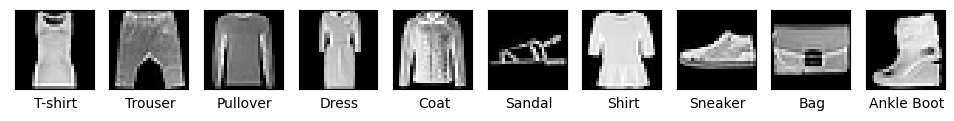

In [5]:
class_examples = []
for class_label in range(0, len(unique_classes)):
  class_examples.append(np.random.choice(np.where(training_class_labels == class_label)[0], 1))

# Visualize 10 random images of the training set to get a "feel" of our classification problem
f, position = plt.subplots(1,len(unique_classes), figsize=(12,12))

for image in range(len(unique_classes)):
  figure = position[image].\
     imshow(tr_x[class_examples[image],:].reshape(28, 28), # 28x28 images
            interpolation='nearest', 
            cmap = 'gray')
  # Hide axes
  figure.axes.get_xaxis().set_visible(False)
  figure.axes.get_yaxis().set_visible(False)
  # Annotate images with the corresponding class labes
  position[image].\
  text(14, 33, '{}'.format(class_mapping[training_class_labels[class_examples[image][0]].numpy()]), fontsize=10, 
       horizontalalignment='center', verticalalignment='center')

plt.show()

In [0]:
def forward_pass(features, weights, bias):

  """ This function passes the entire feature matrix throught the network
  using matrix multiplication. This network has:

  (784 x 300 + 300) + (300 x 100 + 100) + (100 x 10 + 10) = 266,610 tunable parameters.

  """

  # ** First layer (ReLu) **
  # Matrix multiplication and hypothesis of the model using the
  # weights of the first layer and the feature values 
  pre_activated_h1 = tf.matmul(weights[0], features) + bias[0]
  # ReLu activation function: maximum between y' and 0.
  activated_h1 = tf.math.maximum(pre_activated_h1, 0) 

  # ** Second layer (ReLu) **
  # Matrix multiplication and hypothesis of the model using the weights
  # of the second layer and the activated values from the first layer (ReLu)
  pre_activated_h2 = tf.matmul(weights[1], activated_h1) + bias[1]
  # ReLu activation function: maximum between y' and zero
  activated_h2 = tf.math.maximum(pre_activated_h2, 0) # element-wise

  # ** Third layer (Softmax) **
  # Matrix multiplication and hypothesis of the model using the weights
  # of the third layer and the activated values from the second layer (ReLu)
  pre_activated_out = tf.matmul(weights[2], activated_h2) + bias[2]
  # Element-wise exponentiation (e^(hypothesis))
  activated_out = tf.math.exp(pre_activated_out) 

  # Sum e^(hypothesis) for all neurons by training instance (we'll use this to normalize)
  sum_logits = tf.reduce_sum(activated_out, axis=0) 
  # Transform activated values to conditional probabilities (normalization)
  probabilities = tf.math.divide(activated_out, sum_logits) 
  # Clip 'probabilites' tensor to max/min values to avoid underflow (log(0)=undefined)
  probabilities = tf.clip_by_value(probabilities, 1e-10, 1.0)

  return probabilities

def cross_entropy(probabilities, labels, weights, regularization, delta):

  """ This goal of this function is to calculate the Cross Entropy Total Loss
  using regularization. """

  # Cross Entropy Loss is defined as: - log(probability predicted for the correct class)
  loss = tf.reduce_sum(tf.math.multiply(tf.math.log(probabilities), (-labels)), axis=0)
   
  # Set regularization loss to 0 
  reg_loss = 0.0

  if regularization == 'L1':
  # For every layer in the network with weights associated:
    for i in range(len(weights)):
    # Compute the absolute value of w element-wise, sum the entire vector, and add and assign to reg_loss
      reg_loss += tf.reduce_sum(tf.math.abs(weights[i]))
  elif regularization == 'L2':
  # For every layer in the network with weights associated:
    for i in range(len(weights)):
    # Compute square of w element-wise, sum the entire vector, and add and assign to reg_loss
      reg_loss += tf.reduce_sum(tf.math.square(weights[i]))

  # Total loss is calculated as the mean of the individual losses + regularization term
  total_loss = tf.reduce_mean(loss) + (delta * reg_loss)

  return total_loss

def calculate_accuracy(probabilities, labels):

  """ This function calculates the level of accuracy of the model given the 
  predicted probabilities and the true labels of the instances. """

  # Get the index of the actual class from a one-hot encoded vector
  actual_class = tf.argmax(labels, axis=0)
  # Get the index of the predicted class with highest probability
  predicted_class = tf.argmax(probabilities, axis=0) 
  # As the index must be equal to the class, we compare both tensors
  bool_acc = tf.math.equal(predicted_class, actual_class)
  # We count the True values in the 'bool_acc' tensor and divide it by the
  # total number of instances, which gives the level of accuracy 
  accuracy = tf.math.divide(tf.math.count_nonzero(bool_acc), actual_class.shape[0])

  return accuracy

In [0]:
class MultilayerNeuralNetwork():

  def __init__(self):

    self.train_x = []
    self.train_y = []
    self.validation_x = []
    self.validation_y = []
    self.n_classes = 0
    self.n_features = 0
    self.weights = []
    self.biases = []
    self.optimizer = None
    self.regularization = None
    self.delta = 0

  def train_validation_split(self, x, y, split=0.1, print_shape=False):

    """ For both sets (training and validation) we'll calculate the 
    transposed matrix of features. The matrix of class labels is already 
    transposed. """

    validation_index = int(x.shape[0] * split)

    # Train
    self.x_train = tf.cast(x[:-validation_index, :].T, tf.float32) 
    self.y_train = tf.cast(y[:, :-validation_index], tf.float32) 
    
    # Validation
    self.x_validation = tf.cast(x[-validation_index:, :].T, tf.float32)
    self.y_validation = tf.cast(y[:, -validation_index:], tf.float32) 

    # Store number of features and classes 
    self.n_features = self.x_train.shape[0]
    self.n_classes = self.y_train.shape[0]

    if print_shape:
      print('Number of classes:', self.n_classes)
      print('Number of features:', self.n_features)
      print('Shape training features:', self.x_train.shape)
      print('Shape validation features:', self.x_validation.shape)
      print('Shape training labels:', self.y_train.shape)
      print('Shape validation labels:', self.y_validation.shape)


  def build_model(self, n_hidden_1, n_hidden_2, regularization, delta):

    """ For future work and out of this assignment's scope, 'build_model' should 
    be highly customizable with parameters that allow us to add a number of 
    specific layers and let the user pick a tf.keras optimizer (not just Adam). """ 

    # Weights and biases (random initialization using normal distribution)
    self.weights = [tf.Variable( # Layer 1 
                        tf.random.normal(shape=[n_hidden_1, self.n_features], 
                                         mean=0.0, stddev=0.05, dtype=tf.float32), 
                        name='w1_relu'),
                    tf.Variable( # Layer 2
                        tf.random.normal(shape=[n_hidden_2, n_hidden_1], 
                                         mean=0.0, stddev=0.05, dtype=tf.float32), 
                        name='w2_relu'),
                    tf.Variable( # Layer 3
                        tf.random.normal(shape=[self.n_classes, n_hidden_2], 
                                         mean=0.0, stddev=0.05, dtype=tf.float32), 
                        name='w3_softmax')
                    ]
    self.biases = [tf.Variable( # Layer 1
                       tf.zeros(shape=[n_hidden_1, 1], dtype=tf.float32), 
                       name='b1_relu'),
                   tf.Variable( # Layer 2
                       tf.zeros(shape=[n_hidden_2, 1], dtype=tf.float32), 
                       name='b2_relu'),
                   tf.Variable( # Layer 3
                       tf.zeros(shape=[self.n_classes, 1], dtype=tf.float32), 
                       name='b3_softmax')
                   ]
    # Optimizer to peform gradient descent
    self.optimizer = tf.keras.optimizers.Adam()
    # Regularization technique
    self.regularization = regularization
    self.delta = delta

    print('\033[1m' + 'Model was successfully built.' + '\033[0m')

  def fit_model(self, iterations, print_feedback=True):

    """ This is the function that runs the training process of the 
    classifier. It'll track total loss and accuracy on both train and validation
    sets. If 'print_feedback' parameter is set to True, it'll also print these 
    metrics on the screen. """

    # Empty Python lists that we'll use to store training/validation data
    loss_train = []
    loss_validation = []
    accuracy_train = []
    accuracy_validation = []
    
    # Main training loop
    for i in range(iterations):
      
      with tf.GradientTape() as tape:
        probabilities = forward_pass(self.x_train, self.weights, self.biases)
        total_loss = cross_entropy(probabilities, self.y_train, self.weights,
                                   self.regularization, self.delta)
        
      # Calculate gradients using tape.gradient and current accuracy of the model
      # on the training set
      # In gradient.tape we concatenate two lists (+) due to weights and biases 
      # being lists containing TF trainable variables
      gradients = tape.gradient(total_loss, self.weights + self.biases)
      accuracy = calculate_accuracy(probabilities, self.y_train)

      # Run the current model on the validation set:
      v_probabilities = forward_pass(self.x_validation, self.weights, self.biases)
      v_total_loss = cross_entropy(v_probabilities, self.y_validation, self.weights,
                                   self.regularization, self.delta)
      v_accuracy = calculate_accuracy(v_probabilities, self.y_validation)

      # Store validation data
      loss_validation.append(v_total_loss.numpy())
      accuracy_validation.append(v_accuracy.numpy())
      # Store training data 
      loss_train.append(total_loss.numpy())
      accuracy_train.append(accuracy.numpy())

      # Apply the gradients using Adam Optimizer
      self.optimizer.apply_gradients(zip(gradients, self.weights + self.biases))
      
      # When 'print_feedback' is set to True it'll the training process
      # on the screen
      if print_feedback:
        print ("Iteration ", i+1, ": train_loss: ", round(total_loss.numpy(),3),\
               "- train_acc: ", round(accuracy.numpy(),3),\
               " val_loss: ", round(v_total_loss.numpy(),3),\
               "- val_acc: ", round(v_accuracy.numpy(),3))
        
    # Store training data in a dictionary
    history = {'Train Loss': loss_train,
               'Train Accuracy': accuracy_train,
               'Validation Loss': loss_validation,
               'Validation Accuracy': accuracy_validation}
    
    return history

In [8]:
# Create an instance of the model
model = MultilayerNeuralNetwork()
# Feed the model with data and perform train/validation split
model.train_validation_split(tr_x, tr_y, split=0.1, print_shape=True)
# Build the model (it'll initialize: weights, biases and optimizer)
# Please see 'build_model' function in the class defined above
# to check how we initiliaze the weights and biases of the model 
model.build_model(n_hidden_1=300, n_hidden_2=100, regularization='L2', delta=0.002)

Number of classes: 10
Number of features: 784
Shape training features: (784, 54000)
Shape validation features: (784, 6000)
Shape training labels: (10, 54000)
Shape validation labels: (10, 6000)
Model was successfully built.


In [9]:
history = model.fit_model(iterations=1000, print_feedback=True)

Iteration  1 : train_loss:  3.619 - train_acc:  0.105  val_loss:  3.619 - val_acc:  0.104
Iteration  2 : train_loss:  3.482 - train_acc:  0.326  val_loss:  3.479 - val_acc:  0.326
Iteration  3 : train_loss:  3.356 - train_acc:  0.418  val_loss:  3.351 - val_acc:  0.42
Iteration  4 : train_loss:  3.23 - train_acc:  0.497  val_loss:  3.223 - val_acc:  0.498
Iteration  5 : train_loss:  3.101 - train_acc:  0.564  val_loss:  3.092 - val_acc:  0.57
Iteration  6 : train_loss:  2.971 - train_acc:  0.612  val_loss:  2.961 - val_acc:  0.624
Iteration  7 : train_loss:  2.84 - train_acc:  0.636  val_loss:  2.829 - val_acc:  0.648
Iteration  8 : train_loss:  2.711 - train_acc:  0.645  val_loss:  2.7 - val_acc:  0.656
Iteration  9 : train_loss:  2.59 - train_acc:  0.646  val_loss:  2.578 - val_acc:  0.66
Iteration  10 : train_loss:  2.476 - train_acc:  0.65  val_loss:  2.463 - val_acc:  0.662
Iteration  11 : train_loss:  2.373 - train_acc:  0.656  val_loss:  2.359 - val_acc:  0.667
Iteration  12 : t

 
****** SUMMARY REPORT ******
---------------------------
Loss on test set: 0.5260000228881836
Accuracy on test set: 0.874
---------------------------
 


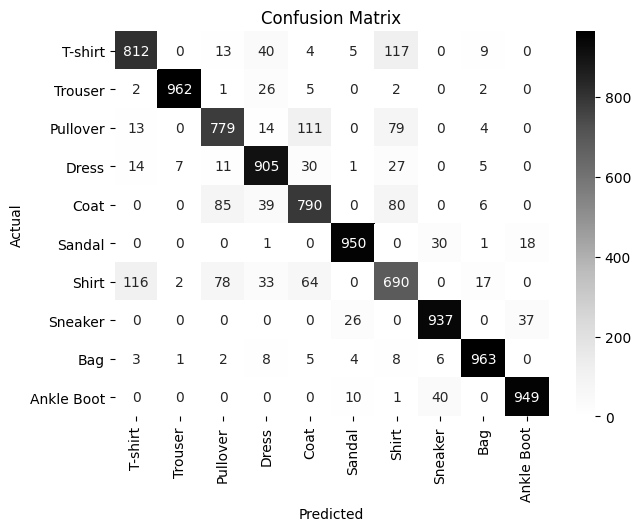

In [10]:
# Test data
x_test = tf.cast(te_x.T, tf.float32) 
y_test = tf.cast(te_y, tf.float32) 
# We can access the model's weights and biases and use them to predict 
# on the test set
probs = forward_pass(x_test, model.weights, model.biases)
test_accuracy = calculate_accuracy(probs, y_test)
test_loss = cross_entropy(probs, y_test, model.weights, model.regularization, model.delta)

# Prepare data for the test summary report
predicted_class = tf.argmax(probs, axis=0) 
actual_class = tf.argmax(y_test, axis=0)
evaluation = [test_loss.numpy(), test_accuracy.numpy()]

# Print the sumamry report
summary_report(evaluation, actual_class, predicted_class, save_fig=False)

# The level of accuracy increases compared to the Softmax Classifier,
# however this Neural Network also struggles to differientate 
# between between t-shirts, shirts and pullovers.

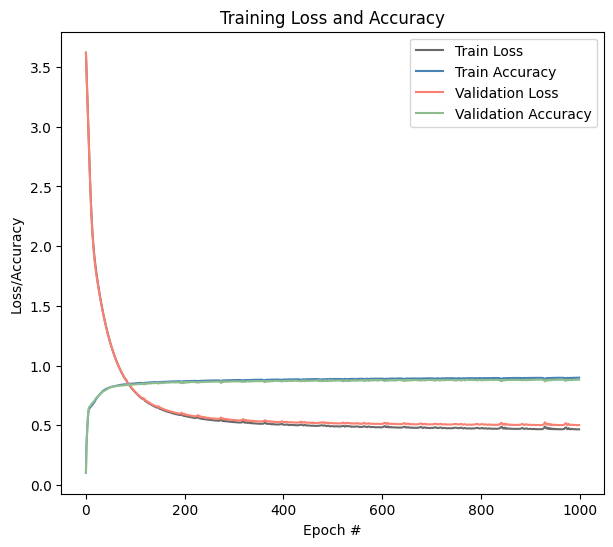

In [11]:
# Plot a linechart of the learning curves
plot_training_data(history, 1000, save_fig=False)

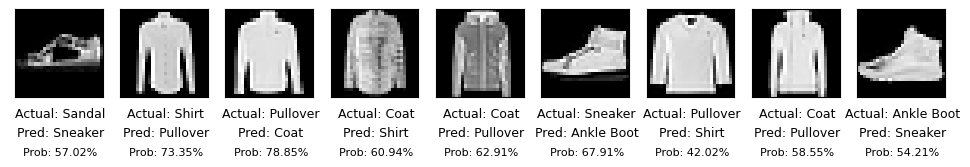

In [12]:
# Plot examples of misclassified images
plot_misclassified_images(10, predicted_class, probs, te_x, actual_class, save_fig=False)